In [ ]:
import numpy as np
import random
import torch

class MinesweeperGame:
    def __init__(self):

        self.breaks = False
        while True:
            self.game_type = input("Enter Game type : E for Easy, M for Medium, H for Hard ").strip().upper()
            if self.game_type in ["E", "M", "H"]:
                break
            print("Invalid game mode, please put in a valid game mode: E, M, or H")

        while True:
            self.logic = input("Do you want to use a Logic bot? enter Y/N for yes or no").strip().upper()
            if self.logic in ["Y", "N"]:
                break
            print("please retry")

        if self.game_type == 'E':
            self.width = 9
            self.height = 9
            self.num_mines = 10

        elif self.game_type == 'M':
            self.width = 16
            self.height = 16
            self.num_mines = 40
        else:
            self.width = 30
            self.height = 16
            self.num_mines = 99
        if self.logic == 'N':
          self.mine_board = torch.zeros((self.height, self.width), dtype=torch.int32)
          self.clue_board = torch.zeros((self.height, self.width), dtype=torch.int32)
          self.clicked_board = torch.zeros((self.height, self.width), dtype=torch.int32)
          self.show_board = torch.full((self.height, self.width), -1, dtype=torch.int32)
          self.print_boards()
          self.x = int(input("Enter x coordinate: ")) - 1
          self.y = int(input("Enter y coordinate: ")) - 1
          print(torch.sum(torch.eq(self.show_board, -1)))

          self.place_mines(self.num_mines,self.x,self.y)
          self.calculate_clues()
          self.click_cell(self.x, self.y)
          self.unclicked = torch.sum(torch.eq(self.show_board, -1))
          print(self.unclicked)
          while True:

              self.print_boards()
              self.x = int(input("Enter x coordinate: ")) - 1
              self.y = int(input("Enter y coordinate: ")) - 1
              self.click_cell(self.x, self.y)
              self.unclicked = torch.sum(torch.eq(self.show_board, -1))
              print(self.unclicked)
              if self.unclicked == self.num_mines:
                  print("You Win!!!!!!!!")
                  self.breaks = True
                  break
              if self.breaks == True:
                  break
        else:

          ## initiazlie x and y
          self.x = random.randint(1, self.width)-1
          self.y = random.randint(1,self.height)-1
          self.clue_number = {}

          self.mine_board = torch.zeros((self.height, self.width), dtype=torch.int32)
          self.clue_board = torch.zeros((self.height, self.width), dtype=torch.int32)
          self.clicked_board = torch.zeros((self.height, self.width), dtype=torch.int32)
          self.show_board = torch.full((self.height, self.width), -1, dtype=torch.int32)
          self.place_mines(self.num_mines,self.x,self.y)
          self.calculate_clues()
          self.print_boards()
          self.cells_remaining = set((x, y) for x in range(self.width) for y in range(self.height) if self.show_board[y,x] == -1)
          self.inferred_mines = set()
          self.inferred_safe = set()
          self.out_data = [self.show_board]
          self.click_cell(self.x, self.y)

          self.print_boards()
          self.update_clue(self.show_board)
          self.before_mines = len(self.inferred_mines)
          self.before_safe = len(self.inferred_safe)
          self.out_data.append(self.show_board)
          while True:



            self.logistics(self.show_board)
            self.out_data.append(self.show_board)
            if self.before_mines == len(self.inferred_mines) and self.before_safe == len(self.inferred_safe):
              break
            self.before_mines = len(self.inferred_mines)
            self.before_safe = len(self.inferred_safe)
            print(self.inferred_mines)


            while self.inferred_safe:
              coards = self.inferred_safe.pop()
              self.click_cell(coards[0],coards[1])
              self.out_data.append(self.show_board)
            self.update_clue(self.show_board)

            print(len(self.cells_remaining))


            self.print_boards()





    def logistics(self,show_board):

      for y in range(self.height):
        for x in range(self.width):
          if self.show_board[y,x] == -1 or (x,y) in self.inferred_mines:
            continue
          neighbours = self.get_neighbours(x,y)
          unrevealed,imines,isafe = self.check_finished_cells(neighbours)
          self.unrevealed = [n for n in neighbours if n in self.cells_remaining and n not in self.inferred_mines]
          self.revealed = [n for n in neighbours if self.show_board[n[1],n[0]] != -1 or n in self.inferred_mines]

          if len(unrevealed) == 0 :
            continue
          if self.clue_number[(x,y)] - len(imines) == len(unrevealed):

            for n in unrevealed:
              self.inferred_mines.add(n)


              if n in self.cells_remaining:
                self.cells_remaining.remove(n)







          elif len(neighbours) - self.show_board[y,x] - (len(self.revealed) + len(isafe))  == len(unrevealed):

            for n in unrevealed:

              self.inferred_safe.add(n)



    def check_finished_cells(self,neighbours):

      self.count = []
      self.im = []
      self.iss = []
      for n in neighbours:
        if n in self.cells_remaining :
          self.count.append(n)
        if n in self.inferred_mines:
          self.im.append(n)
        if n in self.inferred_safe:
          self.iss.append(n)
      return self.count,self.im,self.iss


    def get_neighbours(self,x,y):
      self.neighbours = []
      for i in range(-1,2):
        for j in range(-1,2):
          if ( x + i >= 0 and x + i < self.width and y + j >= 0 and y + j < self.height) and (x, y) != (x + i, y + j):
            self.neighbours.append((x+i,y+j))

      return self.neighbours

    def update_clue(self,show_board):
      for y in range(self.height):
            for x in range(self.width):
                if show_board[y, x] != -1:
                    self.clue_number[(x,y)] = show_board[y,x].item()
    def place_mines(self, num_mines,a,b):
        mines_placed = 0
        while mines_placed < num_mines:
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            if abs(x - a) <= 1 and abs(y - b) <= 1:
              continue
            if self.mine_board[y, x] == 0:
                self.mine_board[y, x] = 1
                mines_placed += 1

    def calculate_clues(self):
        for y in range(self.height):
            for x in range(self.width):
                if self.mine_board[y, x] == 1:
                    self.clue_board[y, x] = -2
                else:
                    count = 0
                    for dy in range(-1, 2):
                        for dx in range(-1, 2):
                            ny, nx = y + dy, x + dx
                            if 0 <= ny < self.height and 0 <= nx < self.width:
                                if self.mine_board[ny, nx] == 1:
                                    count += 1
                    self.clue_board[y, x] = count

    def click_cell(self, x, y):
        if self.mine_board[y, x] == 1:
            print("Mine hit!,Game is Over")
            self.breaks = True
        else:

            if self.clicked_board[y, x] == 0 and self.clue_board[y, x] == 0:
              self.flood_fill(x, y)
            elif self.clicked_board[y, x] == 0:

              self.show_board[y,x] = self.clue_board[y,x]
              if (x,y) in self.cells_remaining:
                self.cells_remaining.remove((x,y))
            else:

              print("You already clicked this cell, please try again")

        self.clicked_board[y, x] = 1

    def print_boards(self):


        self.lst = ['  ']
        self.lst.extend(str(x) for x in range(1,self.width+1))

        for w in self.lst:
          print(w, end = ' ')
        print()
        for i,x in enumerate(self.show_board):
            if i+1 > 9:
                print(i+1, end = ' ')
            else:
                print(i+1, end = '  ')

            for j,y in enumerate(x):
                if y.item() == -1:
                  y = '#'
                else:
                  y = y.item()
                if j+1 > 9:

                    print(y,end = '  ')
                else:
                    print(y, end = ' ')
            print()

    def flood_fill(self, x, y):

      stack = [(x, y)]
      while stack:
          cx, cy = stack.pop()
          if self.clicked_board[cy, cx] == 0:
              self.clicked_board[cy, cx] = 1


              self.show_board[cy, cx] = self.clue_board[cy, cx]
              if (cx,cy) in self.cells_remaining:
                self.cells_remaining.remove((cx,cy))

              if self.clue_board[cy, cx] == 0:
                  for dy in range(-1, 2):
                      for dx in range(-1, 2):
                          ny, nx = cy + dy, cx + dx
                          if 0 <= ny < self.height and 0 <= nx < self.width and self.clicked_board[ny, nx] == 0:
                              stack.append((nx, ny))






game = MinesweeperGame()



In [ ]:

## logic bot

import numpy as np
import random
import torch

class MinesweeperGame_bot:
    def __init__(self, game_type, vb_game_int = 5):



        self.game_type = game_type
        self.vb_game_int = vb_game_int
        if self.game_type == 'E':
            self.width = 9
            self.height = 9
            self.num_mines = 10

        elif self.game_type == 'M':
            self.width = 16
            self.height = 16
            self.num_mines = 40
        elif self.game_type == 'H':
            self.width = 30
            self.height = 16
            self.num_mines = 99
        elif self.game_type == 'VM':
            self.width = 30
            self.height = 30
            self.num_mines = random.randint(0,270)
        elif self.game_type == 'VB':
            print(self.vb_game_int)
            self.width = self.vb_game_int
            self.height = self.vb_game_int
            self.num_mines = int((self.width*self.height)*.2)




        self.x = random.randint(1, self.width)-1
        self.y = random.randint(1,self.height)-1
        self.clue_number = {}

        self.mine_board = torch.zeros((self.height, self.width), dtype=torch.int32)
        self.clue_board = torch.zeros((self.height, self.width), dtype=torch.int32)
        self.clicked_board = torch.zeros((self.height, self.width), dtype=torch.int32)
        self.show_board = torch.full((self.height, self.width), -1, dtype=torch.int32)

        self.place_mines(self.num_mines,self.x,self.y)
        self.calculate_clues()
        # self.print_boards()
        self.cells_remaining = set((x, y) for x in range(self.width) for y in range(self.height) if self.show_board[y,x] == -1)
        self.inferred_mines = set()
        self.inferred_safe = set()
        self.out_data = [self.show_board.clone()]
        self.out_final= [self.mine_board.clone()]
    def play(self):
        self.num_mines_triggered = 0
        self.num_moves = 1
        self.click_cell(self.x, self.y)
        self.out_data.append(self.show_board.clone())
        self.out_final.append(self.mine_board.clone())
        self.init_board = self.show_board.clone()



        self.update_clue(self.show_board)
        self.before_mines = len(self.inferred_mines)
        self.before_safe = len(self.inferred_safe)

        while True:


          self.clicked_cells = torch.sum((self.show_board >= 0) & (self.show_board <= 8))

          if self.clicked_cells >= self.width*self.height - self.num_mines:
            break


          self.logistics(self.show_board)


          if self.before_mines == len(self.inferred_mines) and self.before_safe == len(self.inferred_safe):
            self.x = random.randint(1, self.width)-1
            self.y = random.randint(1,self.height)-1
            self.click_cell(self.x, self.y)

            if self.num_mines_triggered == 0:
              self.num_moves+=1
              self.out_data.append(self.show_board.clone())
              self.out_final.append(self.mine_board.clone())



          self.before_mines = len(self.inferred_mines)
          self.before_safe = len(self.inferred_safe)

          while self.inferred_safe:
            coards = self.inferred_safe.pop()
            self.click_cell(coards[0],coards[1])
            if self.num_mines_triggered == 0:
              self.num_moves+=1
              self.out_data.append(self.show_board.clone())
              self.out_final.append(self.mine_board.clone())
          self.update_clue(self.show_board)





        if self.clicked_cells == self.width*self.height - self.num_mines and self.num_mines_triggered == 0:
          return 1,self.num_moves,self.num_mines_triggered,self.out_data,self.out_final,self.init_board
        else:
          return 0,self.num_moves,self.num_mines_triggered,self.out_data,self.out_final,self.init_board
    def logistics(self,show_board):

      for y in range(self.height):
        for x in range(self.width):
          if self.show_board[y,x] == -1 or (x,y) in self.inferred_mines:
            continue
          neighbours = self.get_neighbours(x,y)
          unrevealed,imines,isafe = self.check_finished_cells(neighbours)
          self.unrevealed = [n for n in neighbours if n in self.cells_remaining and n not in self.inferred_mines]
          self.revealed = [n for n in neighbours if self.show_board[n[1],n[0]] != -1 and n not in self.inferred_mines]

          if len(unrevealed) == 0 :
            continue
          if self.clue_number[(x,y)] - len(imines) == len(unrevealed):

            for n in unrevealed:
              self.inferred_mines.add(n)


              if n in self.cells_remaining:
                self.cells_remaining.remove(n)


          elif len(neighbours) - self.show_board[y,x] - (len(self.revealed) + len(isafe))  == len(unrevealed):

            for n in unrevealed:

              self.inferred_safe.add(n)



    def check_finished_cells(self,neighbours):

      self.count = []
      self.im = []
      self.iss = []
      for n in neighbours:
        if n in self.cells_remaining :
          self.count.append(n)
        if n in self.inferred_mines:
          self.im.append(n)
        if n in self.inferred_safe:
          self.iss.append(n)
      return self.count,self.im,self.iss


    def get_neighbours(self,x,y):
      self.neighbours = []
      for i in range(-1,2):
        for j in range(-1,2):
          if ( x + i >= 0 and x + i < self.width and y + j >= 0 and y + j < self.height) and (x, y) != (x + i, y + j):
            self.neighbours.append((x+i,y+j))

      return self.neighbours

    def update_clue(self,show_board):
      for y in range(self.height):
            for x in range(self.width):
                if show_board[y, x] != -1:
                    self.clue_number[(x,y)] = show_board[y,x].item()
    def place_mines(self, num_mines,a,b):
        mines_placed = 0
        while mines_placed < num_mines:
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            if abs(x - a) <= 1 and abs(y - b) <= 1:
              continue
            if self.mine_board[y, x] == 0:
                self.mine_board[y, x] = 1
                mines_placed += 1

    def calculate_clues(self):
        for y in range(self.height):
            for x in range(self.width):
                if self.mine_board[y, x] == 1:
                    self.clue_board[y, x] = -2
                else:
                    count = 0
                    for dy in range(-1, 2):
                        for dx in range(-1, 2):
                            ny, nx = y + dy, x + dx
                            if 0 <= ny < self.height and 0 <= nx < self.width:
                                if self.mine_board[ny, nx] == 1:
                                    count += 1
                    self.clue_board[y, x] = count

    def click_cell(self, x, y):
        if self.mine_board[y, x] == 1:

            self.num_mines_triggered+=1
            self.show_board[y, x] = -2
        else:

            if self.clicked_board[y, x] == 0 and self.clue_board[y, x] == 0:
              self.flood_fill(x, y)
            elif self.clicked_board[y, x] == 0:

              self.show_board[y,x] = self.clue_board[y,x]
              if (x,y) in self.cells_remaining:
                self.cells_remaining.remove((x,y))
            else:
              print('cell hit')
              ts = 0

        self.clicked_board[y, x] = 1

    def print_boards(self):

        self.lst = ['  ']
        self.lst.extend(str(x) for x in range(1,self.width+1))

        for w in self.lst:
          print(w, end = ' ')
        print()
        for i,x in enumerate(self.show_board):
            if i+1 > 9:
                print(i+1, end = ' ')
            else:
                print(i+1, end = '  ')

            for j,y in enumerate(x):
                if y.item() == -1:
                  y = '-1'
                else:
                  y = y.item()
                if j+1 > 9:

                    print(y,end = '  ')
                else:
                    print(y, end = ' ')
            print()

    def flood_fill(self, x, y):

      stack = [(x, y)]
      while stack:
          cx, cy = stack.pop()
          if self.clicked_board[cy, cx] == 0:
              self.clicked_board[cy, cx] = 1


              self.show_board[cy, cx] = self.clue_board[cy, cx]
              if (cx,cy) in self.cells_remaining:
                self.cells_remaining.remove((cx,cy))

              if self.clue_board[cy, cx] == 0:
                  for dy in range(-1, 2):
                      for dx in range(-1, 2):
                          ny, nx = cy + dy, cx + dx
                          if 0 <= ny < self.height and 0 <= nx < self.width and self.clicked_board[ny, nx] == 0:
                              stack.append((nx, ny))


bot = MinesweeperGame_bot('E')
win,num_moves,mines_triggered,x,y,inital_bpard = bot.play()


In [ ]:

## data generation

from torch.utils.data import TensorDataset, DataLoader

dataset_x_easy = torch.empty((0, 9, 9))
dataset_y_easy = torch.empty((0, 9, 9))

dataset_x_medium = torch.empty((0, 16, 16))
dataset_y_medium = torch.empty((0, 16, 16))

dataset_x_hard = torch.empty((0, 16, 30))
dataset_y_hard = torch.empty((0, 16, 30))

dataset_x_vm = torch.empty((0, 30, 30))
dataset_y_vm = torch.empty((0, 30, 30))

lst_easy = []
lst_medium = []
lst_hard = []
lst_vm = []
for i in range(20):
  print(i)
  bot = MinesweeperGame_bot('E')
  win,num_moves,mines_triggered,train_x,train_y,inital_board = bot.play()
  lst_easy.append([win,num_moves,mines_triggered, inital_board])

  train_x_cat = torch.cat([x.unsqueeze(0) for x in train_x], dim=0)
  train_y_cat = torch.cat([y.unsqueeze(0) for y in train_y], dim=0)

  dataset_x_easy = torch.cat((dataset_x_easy, train_x_cat) , dim = 0)
  dataset_y_easy = torch.cat((dataset_y_easy, train_y_cat), dim=0)

  bot = MinesweeperGame_bot('M')
  win,num_moves,mines_triggered,train_x,train_y,inital_board = bot.play()
  lst_medium.append([win,num_moves,mines_triggered, inital_board])

  train_x_cat = torch.cat([x.unsqueeze(0) for x in train_x], dim=0)
  train_y_cat = torch.cat([y.unsqueeze(0) for y in train_y], dim=0)

  dataset_x_medium = torch.cat((dataset_x_medium, train_x_cat) , dim = 0)
  dataset_y_medium = torch.cat((dataset_y_medium, train_y_cat), dim=0)

  bot = MinesweeperGame_bot('H')
  win,num_moves,mines_triggered,train_x,train_y,inital_board = bot.play()
  lst_hard.append([win,num_moves,mines_triggered, inital_board])

  train_x_cat = torch.cat([x.unsqueeze(0) for x in train_x], dim=0)
  train_y_cat = torch.cat([y.unsqueeze(0) for y in train_y], dim=0)

  dataset_x_hard = torch.cat((dataset_x_hard, train_x_cat) , dim = 0)
  dataset_y_hard = torch.cat((dataset_y_hard, train_y_cat), dim=0)

  bot = MinesweeperGame_bot('VM')
  win,num_moves,mines_triggered,train_x,train_y,inital_board = bot.play()
  lst_vm.append([win,num_moves,mines_triggered, inital_board])

  train_x_cat = torch.cat([x.unsqueeze(0) for x in train_x], dim=0)
  train_y_cat = torch.cat([y.unsqueeze(0) for y in train_y], dim=0)

  dataset_x_vm = torch.cat((dataset_x_vm, train_x_cat) , dim = 0)
  dataset_y_vm = torch.cat((dataset_y_vm, train_y_cat), dim=0)




dataset_x_easy = dataset_x_easy.int()
dataset_x_medium = dataset_x_medium.int()
dataset_x_hard = dataset_x_hard.int()
dataset_x_vm = dataset_x_vm.int()
print(dataset_x_hard.shape)
print(dataset_y_hard.shape)


train_dataset_easy = TensorDataset(dataset_x_easy, dataset_y_easy)
train_loader_easy = DataLoader(train_dataset_easy, batch_size=64, shuffle=True)

train_dataset_medium = TensorDataset(dataset_x_medium, dataset_y_medium)
train_loader_medium = DataLoader(train_dataset_medium, batch_size=64, shuffle=True)

train_dataset_hard = TensorDataset(dataset_x_hard, dataset_y_hard)
train_loader_hard = DataLoader(train_dataset_hard, batch_size=64, shuffle=True)

train_dataset_vm = TensorDataset(dataset_x_vm, dataset_y_vm)
train_loader_vm = DataLoader(train_dataset_vm, batch_size=64, shuffle=True)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
torch.Size([1285, 16, 30])
torch.Size([1285, 16, 30])


In [ ]:

import torch
import torch.nn as nn

class Minesweeper_model(nn.Module):
    def __init__(self, width, height):
        super(Minesweeper_model, self).__init__()
        self.width = width
        self.height = height

        self.embedding = nn.Embedding(11, 10)


        self.conv1 = nn.Conv2d(10, 16, kernel_size=3,padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding =1 )
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding =1 )
        self.bn3 = nn.BatchNorm2d(64)

        self.fc = nn.Linear(64 * width * height, width * height)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.embedding(x + 2)
        x = x.view(-1, self.height, self.width, 10).permute(0, 3, 1, 2)

        x = self.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.relu(self.conv3(x))
        x = self.bn3(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        x = x.view(-1, self.height, self.width)
        return x


In [ ]:
from torch import optim

def train_model(train_loader,alpha,model,loss_fn,epochs):
  optimizer = optim.Adam(model.parameters(), lr=alpha)
  for epoch in range(epochs):
    for x,y in train_loader:
      optimizer.zero_grad()
      output = model(x)
      loss = loss_fn(output,y)
      loss.backward()
      optimizer.step()
    print(loss.item())
  return model







In [ ]:
## training easy model

model = Minesweeper_model(9,9)

model_easy = train_model(train_loader_easy,0.001,model,nn.BCELoss(),7)

0.06249005347490311
0.06127954646945
0.022357244044542313
0.02562168799340725
0.029416261240839958
0.017863305285573006
0.019695980474352837


In [ ]:
# traiining medium model

model = Minesweeper_model(16,16)

model_medium = train_model(train_loader_medium,0.001,model,nn.BCELoss(),7)

0.010145233944058418
0.020307157188653946
0.012110443785786629
0.00045167782809585333
0.010361334308981895
0.01298507396131754
0.0160911176353693


In [ ]:
# training expert model

model = Minesweeper_model(30,16)

model_hard = train_model(train_loader_hard,0.0001,model,nn.BCELoss(),7)

0.055528756231069565
0.024713756516575813
0.014343471266329288
0.007432575337588787
0.0015875977696850896
0.008907065726816654
0.0014414798934012651


In [ ]:
## training variable mine model

model = Minesweeper_model(30,30)

model_vm = train_model(train_loader_vm,0.0001,model,nn.BCELoss(),7)

0.008760583586990833
0.001933370716869831
0.000233510960242711
0.0017229645745828748
0.0027427077293395996
0.000554259866476059
0.0020153981167823076


In [ ]:

## neural netwokt

import numpy as np
import random
import torch

class MinesweeperGame_NNbot:
    def __init__(self, game_type, model, vb_game_ints = 5):



        self.game_type = game_type
        self.model = model
        self.vb_game_ints = vb_game_ints
        if self.game_type == 'E':
            self.width = 9
            self.height = 9
            self.num_mines = 10

        elif self.game_type == 'M':
            self.width = 16
            self.height = 16
            self.num_mines = 40
        elif self.game_type == 'H':
            self.width = 30
            self.height = 16
            self.num_mines = 99
        elif self.game_type == 'VM':
            self.width = 30
            self.height = 30
            self.num_mines = random.randint(0,270)
        elif self.game_type == 'VB':

            self.width = self.vb_game_ints
            self.height = self.vb_game_ints
            self.num_mines = int((self.width*self.height)*.2)




        self.clue_number = {}

        self.mine_board = torch.zeros((self.height, self.width), dtype=torch.int32)
        self.clue_board = torch.zeros((self.height, self.width), dtype=torch.int32)
        self.clicked_board = torch.zeros((self.height, self.width), dtype=torch.int32)
        self.show_board = torch.full((self.height, self.width), -1, dtype=torch.int32)



        self.out_data = [self.show_board.clone()]
        self.out_final= [self.mine_board.clone()]
    def play(self):
        self.coards = self.logistics(self.show_board,self.model)
        self.y,self.x = self.coards
        self.place_mines(self.num_mines,self.x.item(),self.y.item())
        self.calculate_clues()
        self.click_cell(self.x.item(), self.y.item())



        self.num_mines_triggered = 0
        self.click_cell(self.x, self.y)

        self.update_clue(self.show_board)
        self.num_moves =1
        while True:



          self.coards = self.logistics(self.show_board,self.model)
          self.y,self.x = self.coards

          self.click_cell(self.x.item(), self.y.item())

          self.clicked_cells = torch.sum((self.show_board >= 0) & (self.show_board <= 8))
          if self.num_mines_triggered == 0:
            self.num_moves+=1
          if self.clicked_cells>= self.width*self.height - self.num_mines :
            break






        if self.clicked_cells == self.width*self.height - self.num_mines and self.num_mines_triggered == 0:
          return 1,self.num_mines_triggered,self.num_moves
        else:
          return 0,self.num_mines_triggered,self.num_moves

    def logistics(self,show_board,model):
      self.clones = show_board.clone().float().unsqueeze(0)


      output = self.model(self.clones)

      output = torch.flatten(output)

      sorted,indices = torch.sort(output)



      for z in indices:
        coords = torch.unravel_index(z, (self.height, self.width))
        if self.clicked_board[coords[0].item(),coords[1].item()] == 0:

          return coords



      return coords


    def check_finished_cells(self,neighbours):

      self.count = []
      self.im = []
      self.iss = []
      for n in neighbours:
        if n in self.cells_remaining :
          self.count.append(n)
        if n in self.inferred_mines:
          self.im.append(n)
        if n in self.inferred_safe:
          self.iss.append(n)
      return self.count,self.im,self.iss


    def get_neighbours(self,x,y):
      self.neighbours = []
      for i in range(-1,2):
        for j in range(-1,2):
          if ( x + i >= 0 and x + i < self.width and y + j >= 0 and y + j < self.height) and (x, y) != (x + i, y + j):
            self.neighbours.append((x+i,y+j))

      return self.neighbours

    def update_clue(self,show_board):
      for y in range(self.height):
            for x in range(self.width):
                if show_board[y, x] != -1:
                    self.clue_number[(x,y)] = show_board[y,x].item()
    def place_mines(self, num_mines,a,b):
        mines_placed = 0
        while mines_placed < num_mines:
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            if abs(x - a) <= 1 and abs(y - b) <= 1:
              continue
            if self.mine_board[y, x] == 0:
                self.mine_board[y, x] = 1
                mines_placed += 1

    def calculate_clues(self):
        for y in range(self.height):
            for x in range(self.width):
                if self.mine_board[y, x] == 1:
                    self.clue_board[y, x] = -2
                else:
                    count = 0
                    for dy in range(-1, 2):
                        for dx in range(-1, 2):
                            ny, nx = y + dy, x + dx
                            if 0 <= ny < self.height and 0 <= nx < self.width:
                                if self.mine_board[ny, nx] == 1:
                                    count += 1
                    self.clue_board[y, x] = count

    def click_cell(self, x, y):
        if self.mine_board[y, x] == 1:

            self.show_board[y, x] = -2
            self.num_mines_triggered+=1
        else:

            if self.clicked_board[y, x] == 0 and self.clue_board[y, x] == 0:
              self.flood_fill(x, y)
            elif self.clicked_board[y, x] == 0:

              self.show_board[y,x] = self.clue_board[y,x]


        self.clicked_board[y, x] = 1

    def print_boards(self):


        for w in self.lst:
          print(w, end = ' ')
        print()
        for i,x in enumerate(self.show_board):
            if i+1 > 9:
                print(i+1, end = ' ')
            else:
                print(i+1, end = '  ')

            for j,y in enumerate(x):
                if y.item() == -1:
                  y = '-1'
                else:
                  y = y.item()
                if j+1 > 9:

                    print(y,end = '  ')
                else:
                    print(y, end = ' ')
            print()


    def flood_fill(self, x, y):

      stack = [(x, y)]
      while stack:
          cx, cy = stack.pop()
          if self.clicked_board[cy, cx] == 0:
              self.clicked_board[cy, cx] = 1


              self.show_board[cy, cx] = self.clue_board[cy, cx]


              if self.clue_board[cy, cx] == 0:
                  for dy in range(-1, 2):
                      for dx in range(-1, 2):
                          ny, nx = cy + dy, cx + dx
                          if 0 <= ny < self.height and 0 <= nx < self.width and self.clicked_board[ny, nx] == 0:
                              stack.append((nx, ny))




In [ ]:

## getting data for stats for task 1
lst_nn_easy = []
lst_nn_medium = []
lst_nn_hard = []
lst_nn_vm = []
for i in range(200):
  print(i)
  game = MinesweeperGame_NNbot('E',model_easy)
  lst_nn_easy.append(game.play())

  game = MinesweeperGame_NNbot('M',model_medium)
  lst_nn_medium.append(game.play())

  game = MinesweeperGame_NNbot('H',model_hard)
  lst_nn_hard.append(game.play())

  game = MinesweeperGame_NNbot('VM',model_vm)
  lst_nn_vm.append(game.play())
print(lst_nn_easy)
print(lst_nn_medium)
print(lst_nn_hard)
print(lst_nn_vm)

In [ ]:

## stats for easy

from scipy import stats
from statistics import mean

wins = []
mines_triggered = []
moves_before_mines = []

wins_nn = []
mines_triggered_nn = []
moves_before_mines_nn = []
for x in lst_easy:

  wins.append(x[0])
  mines_triggered.append(x[2])
  moves_before_mines.append(x[1])
for x in lst_nn_easy:
  wins_nn.append(x[0])
  mines_triggered_nn.append(x[1])
  moves_before_mines_nn.append(x[2])


se_win = stats.tstd(wins)/np.sqrt(len(wins))
means = np.mean(wins)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for wins triggered Logic Easy')
print()
se_win = stats.tstd(wins_nn)/np.sqrt(len(wins_nn))
means = np.mean(wins_nn)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for Wins triggered NN Easy')
print()
se_win = stats.tstd(mines_triggered)/np.sqrt(len(mines_triggered))
means = np.mean(mines_triggered)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for mines triggered Logic Easy')
print()
se_win = stats.tstd(mines_triggered_nn)/np.sqrt(len(mines_triggered_nn))
means = np.mean(mines_triggered_nn)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for mines triggered NN Easy')
print()

se_win = stats.tstd(moves_before_mines)/np.sqrt(len(moves_before_mines))
means = np.mean(moves_before_mines)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for moves before mines Logic Easy')
print()
se_win = stats.tstd(moves_before_mines_nn)/np.sqrt(len(moves_before_mines_nn))
means = np.mean(moves_before_mines_nn)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for moves before mines NN Easy')
print()

0.6894411077058114 1.0105588922941886 confidence interval for mines triggered Logic Easy

0.0 0.0 confidence interval for Wins triggered NN Easy

-0.1931354686836103 0.9931354686836104 confidence interval for mines triggered Logic Easy

8.732509013039362 9.087490986960638 confidence interval for mines triggered NN Easy

16.884055685729276 23.91594431427072 confidence interval for moves before mines Logic Easy

2.955802116604373 3.614197883395627 confidence interval for moves before mines NN Easy



In [ ]:

## stats for medium

from scipy import stats
from statistics import mean

wins = []
mines_triggered = []
moves_before_mines = []

wins_nn = []
mines_triggered_nn = []
moves_before_mines_nn = []
for x in lst_medium:

  wins.append(x[0])
  mines_triggered.append(x[2])
  moves_before_mines.append(x[1])
for x in lst_nn_medium:
  wins_nn.append(x[0])
  mines_triggered_nn.append(x[1])
  moves_before_mines_nn.append(x[2])


se_win = stats.tstd(wins)/np.sqrt(len(wins))
means = np.mean(wins)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for mines triggered Logic Medium')
print()
se_win = stats.tstd(wins_nn)/np.sqrt(len(wins_nn))
means = np.mean(wins_nn)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for Wins triggered NN Medium')
print()
se_win = stats.tstd(mines_triggered)/np.sqrt(len(mines_triggered))
means = np.mean(mines_triggered)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for mines triggered Logic Medium')
print()
se_win = stats.tstd(mines_triggered_nn)/np.sqrt(len(mines_triggered_nn))
means = np.mean(mines_triggered_nn)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for mines triggered NN Medium')
print()

se_win = stats.tstd(moves_before_mines)/np.sqrt(len(moves_before_mines))
means = np.mean(moves_before_mines)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for moves before mines Logic Medium')
print()
se_win = stats.tstd(moves_before_mines_nn)/np.sqrt(len(moves_before_mines_nn))
means = np.mean(moves_before_mines_nn)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for moves before mines NN Medium')
print()

-0.010558892294188549 0.31055889229418854 confidence interval for mines triggered Logic Medium

0.0 0.0 confidence interval for Wins triggered NN Medium

8.3120146946682 19.8879853053318 confidence interval for mines triggered Logic Medium

39.077825767743334 39.40217423225667 confidence interval for mines triggered NN Medium

47.5607495443992 76.9392504556008 confidence interval for moves before mines Logic Medium

6.0 6.0 confidence interval for moves before mines NN Medium



In [ ]:

## stats for expert

from scipy import stats
from statistics import mean
### doing 95 percent confidence interval
wins = []
mines_triggered = []
moves_before_mines = []

wins_nn = []
mines_triggered_nn = []
moves_before_mines_nn = []
for x in lst_hard:

  wins.append(x[0])
  mines_triggered.append(x[2])
  moves_before_mines.append(x[1])
for x in lst_nn_hard:
  wins_nn.append(x[0])
  mines_triggered_nn.append(x[1])
  moves_before_mines_nn.append(x[2])


se_win = stats.tstd(wins)/np.sqrt(len(wins))
means = np.mean(wins)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for mines triggered Logic Hard')
print()
se_win = stats.tstd(wins_nn)/np.sqrt(len(wins_nn))
means = np.mean(wins_nn)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for Wins triggered NN Hard')
print()
se_win = stats.tstd(mines_triggered)/np.sqrt(len(mines_triggered))
means = np.mean(mines_triggered)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for mines triggered Logic Hard')
print()
se_win = stats.tstd(mines_triggered_nn)/np.sqrt(len(mines_triggered_nn))
means = np.mean(mines_triggered_nn)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for mines triggered NN Hard')
print()

se_win = stats.tstd(moves_before_mines)/np.sqrt(len(moves_before_mines))
means = np.mean(moves_before_mines)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for moves before mines Logic Hard')
print()
se_win = stats.tstd(moves_before_mines_nn)/np.sqrt(len(moves_before_mines_nn))
means = np.mean(moves_before_mines_nn)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for moves before mines NN Hard')
print()

0.0 0.0 confidence interval for mines triggered Logic Hard

0.0 0.0 confidence interval for Wins triggered NN Hard

67.55311504387821 161.5468849561218 confidence interval for mines triggered Logic Hard

98.1759322507875 98.50406774921251 confidence interval for mines triggered NN Hard

38.421122097550665 88.07887790244934 confidence interval for moves before mines Logic Hard

4.04229228423102 5.06770771576898 confidence interval for moves before mines NN Hard



In [ ]:

## stats for task 2

from scipy import stats
from statistics import mean
### doing 95 percent confidence interval
wins = []
mines_triggered = []
moves_before_mines = []

wins_nn = []
mines_triggered_nn = []
moves_before_mines_nn = []
for x in lst_vm:

  wins.append(x[0])
  mines_triggered.append(x[2])
  moves_before_mines.append(x[1])
for x in lst_nn_vm:
  wins_nn.append(x[0])
  mines_triggered_nn.append(x[1])
  moves_before_mines_nn.append(x[2])


se_win = stats.tstd(wins)/np.sqrt(len(wins))
means = np.mean(wins)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for wins triggered Logic Variable Mines')
print()
se_win = stats.tstd(wins_nn)/np.sqrt(len(wins_nn))
means = np.mean(wins_nn)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for Wins triggered NN Variable Mines')
print()
se_win = stats.tstd(mines_triggered)/np.sqrt(len(mines_triggered))
means = np.mean(mines_triggered)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for mines triggered Logic Variable Mines')
print()
se_win = stats.tstd(mines_triggered_nn)/np.sqrt(len(mines_triggered_nn))
means = np.mean(mines_triggered_nn)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for mines triggered NN Variable Mines')
print()

se_win = stats.tstd(moves_before_mines)/np.sqrt(len(moves_before_mines))
means = np.mean(moves_before_mines)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for moves before mines Logic Variable Mines')
print()
se_win = stats.tstd(moves_before_mines_nn)/np.sqrt(len(moves_before_mines_nn))
means = np.mean(moves_before_mines_nn)
print(means-1.96*se_win,means+1.96*se_win, 'confidence interval for moves before mines NN Variable Mines')
print()

0.22629954238571146 0.6737004576142885 confidence interval for mines triggered Logic Variable Mines

-0.003824426710332212 0.023824426710332212 confidence interval for Wins triggered NN Variable Mines

32.49301534128513 258.8069846587149 confidence interval for mines triggered Logic Variable Mines

122.03780082059718 144.8021991794028 confidence interval for mines triggered NN Variable Mines

63.22056222000171 153.6794377799983 confidence interval for moves before mines Logic Variable Mines

3.186083828204347 4.133916171795653 confidence interval for moves before mines NN Variable Mines



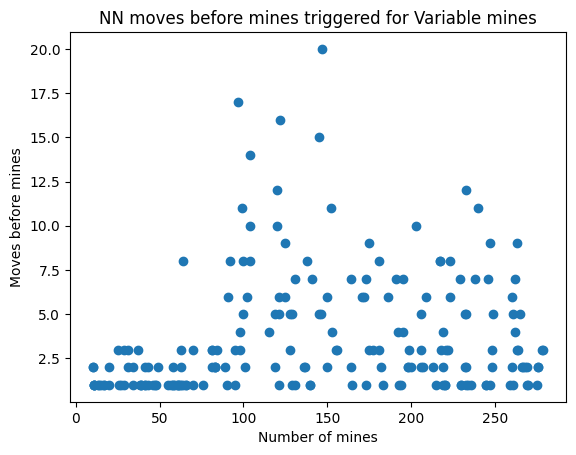

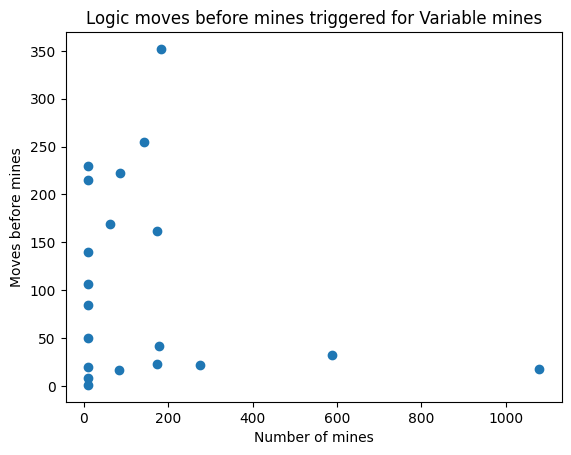

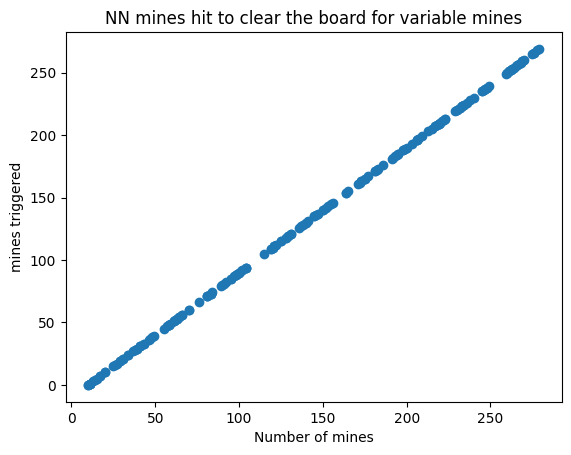

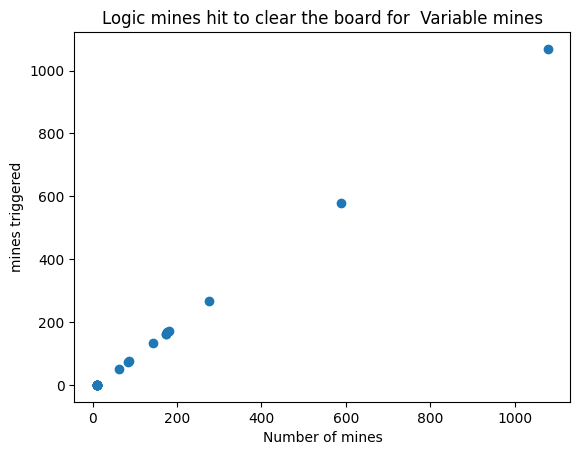

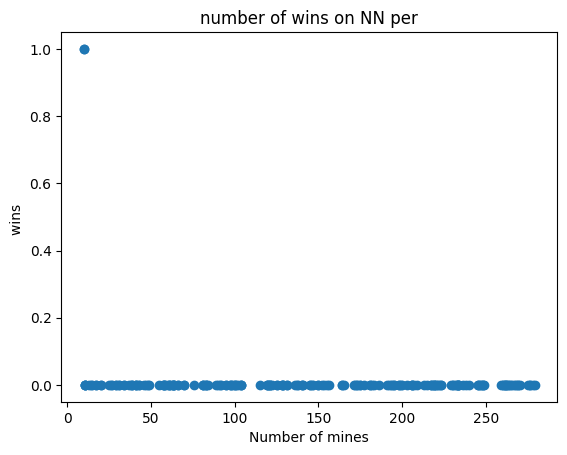

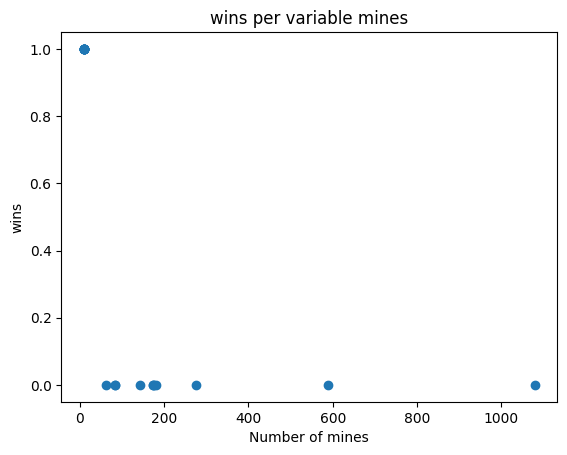

In [ ]:

## plots for task 2

wins = []
mines_triggered = []
moves_before_mines = []

wins_nn = []
mines_triggered_nn = []
moves_before_mines_nn = []
for x in lst_vm:

  wins.append(x[0])
  mines_triggered.append(x[2])
  moves_before_mines.append(x[1])
for x in lst_nn_vm:
  wins_nn.append(x[0])
  mines_triggered_nn.append(x[1])
  moves_before_mines_nn.append(x[2])
Ks_nn = []
Ks = []
# for x in mines_triggered_nn:
#   Ks_nn.append(x+10)
# Ks_nn
# for x in mines_triggered:
#   Ks.append(x+10)
Ks
plt.scatter(Ks_nn,moves_before_mines_nn)
plt.title("NN moves before mines triggered for Variable mines")
plt.xlabel("Number of mines")
plt.ylabel("Moves before mines")
plt.pause(0.1)
plt.scatter(Ks,moves_before_mines)
plt.title("Logic moves before mines triggered for Variable mines")
plt.xlabel("Number of mines")
plt.ylabel("Moves before mines")
plt.pause(0.1)
plt.scatter(Ks_nn,mines_triggered_nn)
plt.title("NN mines hit to clear the board for variable mines")
plt.xlabel("Number of mines")
plt.ylabel("mines triggered")
plt.pause(0.1)
plt.scatter(Ks,mines_triggered)
plt.title("Logic mines hit to clear the board for  Variable mines")
plt.xlabel("Number of mines")
plt.ylabel("mines triggered")

plt.pause(0.1)
plt.scatter(Ks_nn,wins_nn)
plt.title("number of wins on NN per")
plt.xlabel("Number of mines")
plt.ylabel("wins ")
plt.pause(0.1)
plt.scatter(Ks,wins)
plt.title("wins per variable mines")
plt.xlabel("Number of mines")
plt.ylabel("wins")
plt.show()




In [ ]:
## task 3 sequence generation

def gen_batch_digi(batch_size, random_integers):
  stacked_tensor = []
  targets_full = []
  # random_integers = random.randint(5, 50)
  # random_integers = 50
  print(random_integers)
  dataset_x = torch.empty((0, random_integers, random_integers))
  dataset_y = torch.empty((0, random_integers, random_integers))
  wins = []
  moves = []
  mines_triggereda = []
  for i in range(batch_size):





    game = MinesweeperGame_bot('VB',random_integers)

    win,num_moves,mines_triggered,train_x,train_y,_ = game.play()
    wins.append(win)
    moves.append(num_moves)
    mines_triggereda.append(mines_triggered)
    train_x_cat = torch.cat([x.unsqueeze(0) for x in train_x], dim=0)
    train_y_cat = torch.cat([y.unsqueeze(0) for y in train_y], dim=0)

    dataset_x = torch.cat((dataset_x, train_x_cat) , dim = 0)
    dataset_y = torch.cat((dataset_y, train_y_cat), dim=0)

  return dataset_x,dataset_y,wins,moves,mines_triggereda


In [ ]:
import torch
import torch.nn as nn

class MinesweeperCNN_task_3(nn.Module):
    def __init__(self):
        super(MinesweeperCNN_task_3, self).__init__()
        self.convolutional1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.convolutional2 = nn.Conv2d(64, 64, 3, padding=1)
        self.convvolutional3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):

        x = x.unsqueeze(1)
        x = self.convolutional1(x)
        x = nn.ReLU()(x)
        x = self.convolutional2(x)
        x = nn.ReLU()(x)
        x = self.convolutional3(x)
        x = nn.Sigmoid()(x)
        x = x.squeeze(1)
        return x


In [ ]:

### training for task 3
from torch import optim
import random
def train_model_2(alpha,model,loss_fn,epochs):
  optimizer = optim.Adam(model.parameters(), lr=alpha)
  wins = []
  moves = []
  mines_triggereda = []
  for epoch in range(1):
    for i in range(5):
      optimizer.zero_grad()
      ints = random.randint(5, 50)
      x,y,win,num_moves,mines_triggered = gen_batch_digi(1,ints)
      wins.extend(win)
      moves.extend(num_moves)
      mines_triggereda.extend(mines_triggered)
      x = x.float()
      y = y.float()
      output = model(x)
      loss = loss_fn(output,y)
      loss.backward()
      optimizer.step()
      print(loss.item())
      print(i)
  return model,wins,moves,mines_triggereda
model = MinesweeperCNN_task_3()

model_3,wins,moves,mines_triggered = train_model_2(0.001,model,nn.BCELoss(),7)


49
49
0.6630611419677734
0
40
40
0.6057036519050598
1
27
27
0.5343003869056702
2
47
47
0.5026777982711792
3
45
45
0.5000675916671753
4


In [ ]:

model_3
vb_wins = []
vb_triggered = []
vb_moves = []
for _ in range(5):
  ints = random.randint(5, 50)
  print(ints)
  bot = MinesweeperGame_NNbot('VB',model_3,ints)
  wins,mines_triggered,moves = bot.play()
  vb_wins.append(wins)
  vb_triggered.append(mines_triggered)
  vb_moves.append(moves)
print(vb_wins)
print(vb_triggered)
print(vb_moves)


5
27
20
49
22
[0, 0, 0, 0, 0]
[5, 143, 80, 478, 95]
[3, 8, 7, 2, 2]


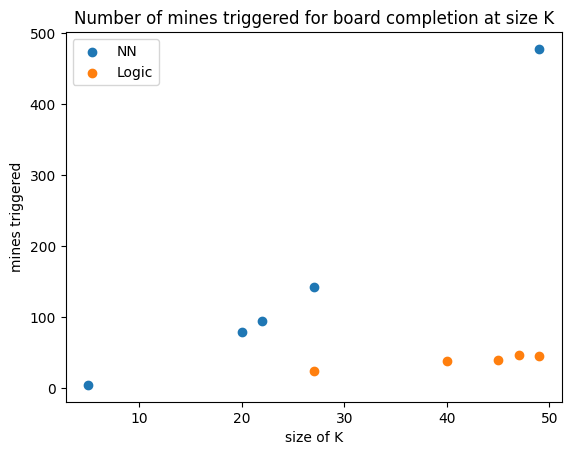

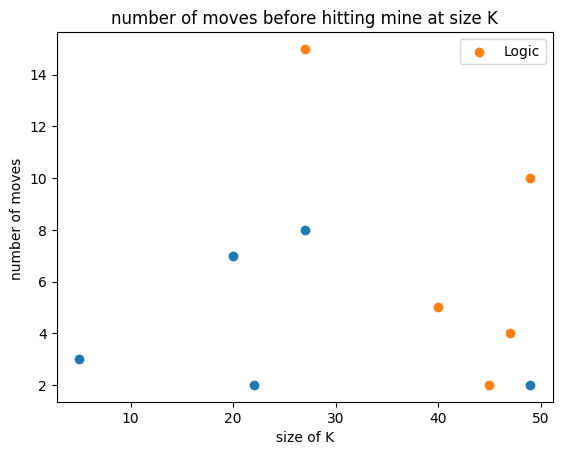

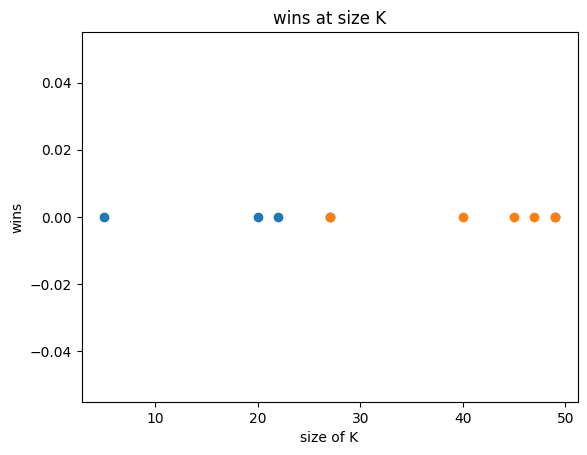

In [ ]:
## task 3 plots

import matplotlib.pyplot as plt
plt.scatter([5,27,20,49,22],vb_triggered, label = 'NN')
plt.scatter([49,40,27,47,45],[46,39,24,47,40], label = 'Logic')
plt.xlabel('size of K')
plt.ylabel('mines triggered')
plt.title('Number of mines triggered for board completion at size K')
plt.legend()
plt.pause(0.1)
plt.xlabel('size of K')
plt.ylabel('number of moves ')
plt.title('number of moves before hitting mine at size K')
plt.scatter([5,27,20,49,22],vb_moves)
plt.scatter([49,40,27,47,45],[10,5,15,4,2], label = 'Logic')
plt.legend()
plt.pause(0.1)
plt.xlabel('size of K')
plt.ylabel('wins')
plt.title('wins at size K')
plt.scatter([5,27,20,49,22],[0,0,0,0,0], label = "NN")
plt.scatter([49,40,27,47,45],[0,0,0,0,0], label = 'Logic')
plt.show()



In [ ]:
###### PLEASE NOTE
model_easy # this is the model for easy
model_medium # this is the model for medium
model_hard # this is the model for hard
model_vm # this is the model for variable mines
model_3 # this is the model for variable sized boards